# Hyper-personalization Through Product Reviews: Exploring New Market Opportunites

A multi-modal approach to generating user recommendations.

## Import Libraries and Define File Paths

In [255]:
import os
import glob
import json
import scipy
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import threadpoolctl
from tqdm import tqdm
import warnings
from collections import defaultdict
from implicit.als import AlternatingLeastSquares as ALS
from lightfm import LightFM
from lightfm.data import Dataset as LightFMDataset
from scipy.sparse import coo_matrix
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.cross_validation import random_train_test_split
from math import log2 as log
from scipy.spatial import distance
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from implicit.evaluation import (AUC_at_k,
                                 mean_average_precision_at_k,
                                 ndcg_at_k, precision_at_k)
from implicit.evaluation import train_test_split
from unidecode import unidecode

warnings.simplefilter(action='ignore', category=FutureWarning)

dir = "../dataset/utility"

if not os.path.exists(dir):
    os.mkdir(dir)

## Define Utility Functions and Dataset Generation Functions

In [256]:
def clean_str(x):
    forbidden_chars = [',', '-', '?', '(', ')',
                       '~', '*', '.', '!']
    x = unidecode(x)
    x = '_'.join(x.replace('& ', '').split(' '))
    x = x.lower().strip()
    for c in forbidden_chars:
        x = x.replace(c, '')
    return x

def items_and_reviews_to_dataframe(json_data):
    products = []
    reviews = []
    asins = []
    asin_product_mapping = []
    for product_data in json_data:
        product = {}
        if ('body' not in product_data or 'reviews' not in product_data['body']
            or 'productInformation' not in product_data['body']):
            continue

        reviews_data = product_data['body'].get('reviews', [])
        product_name = product_data['body'].get('name', 'Unknown Product')
        product_data = product_data['body']
        asin = product_data['canonicalUrl'].split('/')[-1].lower()

        if not reviews_data or len(reviews_data) == 0:
            continue
        
        ignore = ['dimensions', 'country_of_origin', 'batteries_included',
                  'weight', 'height', 'size', 'model', 'manufacturer',
                  'specifications', 'voltage', 'volts', '12v', 'climate_pledge',
                  'capacity', 'number_of_items', 'import', 'lxwxh', 'product'
                  'included']

        product['ASIN'] = asin

        if asin not in asins:
            asin_product_mapping.append({
                'ASIN': asin,
                'name': product_name
            })
            asins.append(asin)
        breadcrumbs = product_data.get('breadCrumbs', [])
        for bc in breadcrumbs:
            name = clean_str(bc['name'])
            flag = True
            for ig in ignore:
                if ig in name:
                    flag = False
            if flag and '_' in name:
                name_list = name.split("_")
                for n in name_list:
                    product[n] = 1.0
            elif flag:
                product[name] = 1.0
        
        products.append(product)

        review = {}
        for r in reviews_data:
            review['ASIN'] = asin
            review['ProductName'] = clean_str(product_name)
            review['reviewerID'] = r['reviewerName'] + '_' + r['reviewerLink'].split('/')[-1].split('.')[-1]
            review['price'] = product_data.get('rawPrice', 0)
            reviewRating = re.findall(r'(\d+\.\d+)', r['reviewRating'])
            reviewLocation = r['reviewDate'].split('on')[0].split(' in ')[-1].replace('the ', '')
            reviewDate = re.findall(r'on (.+)$', r['reviewDate'])
            reviewVotes = re.findall(r'(\d+)', r['reviewVotes'])
            review['image'] = product_data.get('mainImage', None)
            
            if reviewRating:
                review['customerReview'] = float(reviewRating[0])
            else:
                review['customerReview'] = np.nan
            if reviewDate:
                review['reviewDate'] = reviewDate[0]
            else:
                review['reviewDate'] = 'Unknown'
            if reviewLocation:
                review['reviewLocation'] = reviewLocation
            else:
                review['reviewLocation'] = 'Unknown'
            if reviewVotes:
                review['reviewVotes'] = reviewVotes[0]
            else:
                review['reviewVotes'] = 0
            reviews.append(review)
            review = {}
    all_reviews_df = pd.DataFrame(reviews)
    all_items_df = pd.DataFrame(products)
    asins_df = pd.DataFrame(asin_product_mapping)
    return all_reviews_df, all_items_df, asins_df

def get_all_json_data():
    base_dir = '../dataset/extracts/amazon'
    all_json_data = []
    for root, dirs, files in os.walk(base_dir):
        for dir in dirs:
            items_path = os.path.join(root, dir, 'items')
            if os.path.exists(items_path):
                json_files = glob.glob(os.path.join(items_path, '*.json'))
                
                for json_file in tqdm(json_files, desc=f'Loading JSON Files in {dir}'):
                    try:
                        with open(json_file, "r") as f:
                            all_json_data.append(json.load(f))
                    except json.JSONDecodeError:
                        print(f"Error loading JSON from file {json_file}: file is empty or not a valid JSON.")
                    except Exception as e:
                        print(f"Unexpected error loading JSON from file {json_file}: {e}")
    return all_json_data

def load_dataset():
    items_df = pd.read_csv(f"{dir}/itemset_preprocessed.csv")
    items_df.set_index("ASIN", inplace=True)
 
    df_utility = pd.read_csv(f"{dir}/utility_topn.csv", index_col=0)
    df_utility.set_index("reviewerID", inplace=True)

    reviews_df = pd.read_csv(f"{dir}/reviews.csv")
    reviews_df.set_index('reviewerID', inplace=True)
    
    asins_df = pd.read_csv(f"{dir}/asin_product_mapping.csv")
    asins_df.set_index('ASIN', inplace=True)

    print(f"shape of df_utility: {df_utility.shape}")
    print(f"shape of items_df: {items_df.shape}")
    print(f"shape of asins_df: {asins_df.shape}")
    return items_df, df_utility, reviews_df, asins_df

## Generate the Dataset and Preprocess

### Fetch all json data

In [257]:
all_json_data = get_all_json_data()
all_reviews_df, all_items_df, asins_df = items_and_reviews_to_dataframe(all_json_data)
all_reviews_df = all_reviews_df.replace(np.nan, '', regex=True)
all_reviews_df.drop_duplicates(keep="first", inplace=True)
all_reviews_df.to_csv(f"{dir}/reviews.csv")
all_items_df.drop_duplicates(keep='first', inplace=True)
all_items_df.fillna(0, inplace=True)
asins_df.to_csv(f"{dir}/asin_product_mapping.csv", index=False)

Loading JSON Files in stove: 100%|██████████| 189/189 [00:00<00:00, 4436.21it/s]


Error loading JSON from file ../dataset/extracts/amazon/stove/items/amazon_B07V7JNTLB.json: file is empty or not a valid JSON.


Loading JSON Files in intel amd processor: 100%|██████████| 144/144 [00:00<00:00, 5151.48it/s]


### Preprocess itemset

In [258]:
all_items_df.reset_index(inplace=True)
vc = all_items_df['ASIN'].value_counts()
to_merge = vc.loc[lambda x: x > 1].index.tolist()

all_items_df.set_index('ASIN', inplace=True)
merge_dicts = []
for asin in to_merge:
    merged_row = all_items_df.loc[asin].sum()
    merged_row = merged_row.drop('level_0')
    d = merged_row.to_dict()
    d['ASIN'] = asin
    merge_dicts.append(d)
    all_items_df.drop(asin, inplace=True)
    
merged_df = pd.DataFrame(merge_dicts)
merged_df.set_index('ASIN', inplace=True)
all_items_df = pd.concat([all_items_df, merged_df])
all_items_df.to_csv(f"{dir}/itemset_preprocessed.csv")

### Preprocess userbase

In [259]:
user_ratings_df = all_reviews_df.drop([
    "reviewVotes", "reviewLocation", "reviewDate",
    "ProductName"], axis=1)

groupby_df = user_ratings_df.groupby('reviewerID')
freq = groupby_df.size().reset_index(name='count')
user_ratings_df = pd.merge(user_ratings_df, freq, on='reviewerID', how='left')
user_ratings_df = user_ratings_df.sort_values(['count'], ascending=False)
user_ratings_df = user_ratings_df[user_ratings_df["count"] >= 10]
topn_reviewers = pd.unique(user_ratings_df["reviewerID"])
user_ratings_df.set_index("reviewerID", inplace=True)
user_ratings_df = user_ratings_df.loc[topn_reviewers]
generic_reviewerIDs = user_ratings_df.groupby('reviewerID').count().sort_values('ASIN', ascending=False)[:8].index.tolist()
topn_reviewers = [r for r in topn_reviewers if r not in generic_reviewerIDs]
user_ratings_df = user_ratings_df.loc[topn_reviewers]

rows = []
columns = all_items_df.index.tolist()
columns.append("reviewerID")

for index, data in user_ratings_df.groupby('reviewerID'):
    row = {'reviewerID': index}
    for ind, d in data.iterrows():
        row[d['ASIN']] = d['customerReview']
    rows.append(row)

df_utility = pd.DataFrame(rows, columns=columns)
df_utility.to_csv(f"{dir}/utility_topn.csv")

## Load Dataset

In [260]:
items_df, df_utility, reviews_df, asins_df = load_dataset()

shape of df_utility: (455, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)


# Try all algorithms
We try all algorithms and evaluate the quality of recommendations.
* Neighborhood-based collaborative filtering
    * KNNBasic
    * KNNWithMeans
    * SVD
* Latent-factor based collaborative filtering
    * Alternating Least Squares (ALS)
* Content-based collaborative filtering
    * User profile numeric aggregation with Euclidean distance

## Neighborhood-based Collaborative Filtering

From Surprise

In [261]:
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(melted_user_df, reader)
algos = [KNNBasic(verbose=False), KNNWithMeans(verbose=False), SVD()]

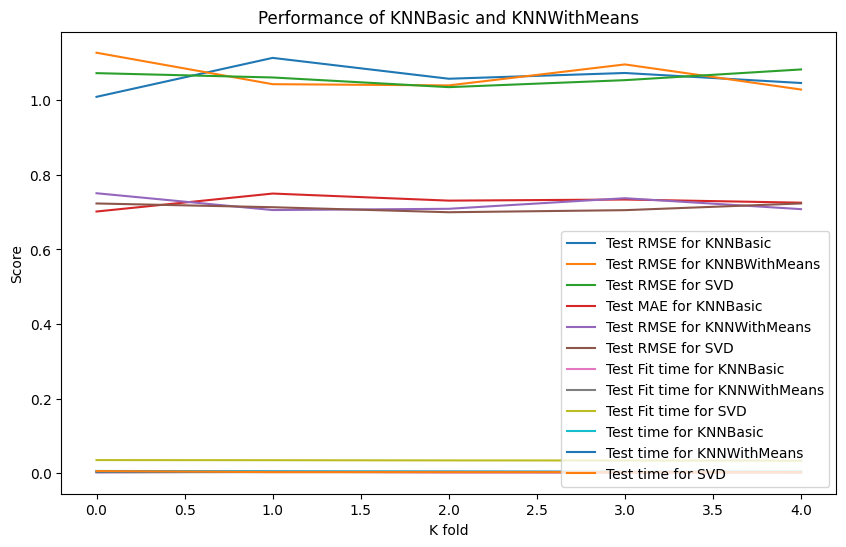

In [262]:
metrics_list = []
for algo in algos:
    metrics = cross_validate(algo, dataset)
    metrics['mean_test_rmse'] = np.mean(metrics['test_rmse'])
    metrics['mean_test_mae'] = np.mean(metrics['test_mae'])
    metrics_list.append(metrics)

k = range(0,5)
plt.figure(figsize=(10, 6))
plt.plot(k, metrics_list[0]['test_rmse'], label='Test RMSE for KNNBasic')
plt.plot(k, metrics_list[1]['test_rmse'], label='Test RMSE for KNNBWithMeans')
plt.plot(k, metrics_list[2]['test_rmse'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['test_mae'], label='Test MAE for KNNBasic')
plt.plot(k, metrics_list[1]['test_mae'], label='Test RMSE for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_mae'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['fit_time'], label='Test Fit time for KNNBasic')
plt.plot(k, metrics_list[1]['fit_time'], label='Test Fit time for KNNWithMeans')
plt.plot(k, metrics_list[2]['fit_time'], label='Test Fit time for SVD')
plt.plot(k, metrics_list[0]['test_time'], label='Test time for KNNBasic')
plt.plot(k, metrics_list[1]['test_time'], label='Test time for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_time'], label='Test time for SVD')
plt.xlabel("K fold")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.title("Performance of KNNBasic and KNNWithMeans")
plt.show()

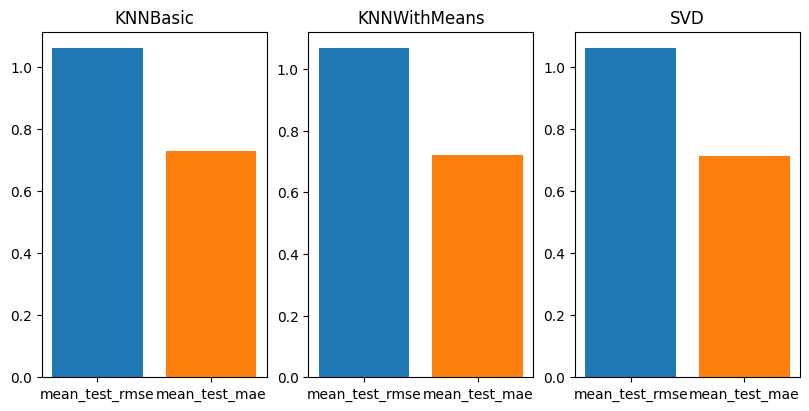

In [263]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in metrics_list:
    for k in m:
        if 'mean' in k:
            axes[ind].bar(k, m[k])
            axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### NDCG, Precision, and Recall

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py and https://github.com/NicolasHug/Surprise/issues/339

In [264]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls
kf = KFold(n_splits=5)

def get_ndcg(surprise_predictions, k_highest_scores=None):
    """ 
    Calculates the ndcg (normalized discounted cumulative gain) from surprise predictions, using sklearn.metrics.ndcg_score and scipy.sparse
  
    Parameters: 
    surprise_predictions (List of surprise.prediction_algorithms.predictions.Prediction): list of predictions
    k_highest_scores (positive integer): Only consider the highest k scores in the ranking. If None, use all. 
  
    Returns: 
    float in [0., 1.]: The averaged NDCG scores over all recommendations
  
    """
    from sklearn.metrics import ndcg_score
    from scipy import sparse
    
    uids = []
    iids = []
    uid_mapping = {}
    iid_mapping = {}

    iter = 0
    for s in surprise_predictions:
        if s.uid in uid_mapping:
            uids.append(uid_mapping[s.uid])
        else:
            uid_mapping[s.uid] = iter
            uids.append(iter)

        if s.iid in iid_mapping:
            iids.append(iid_mapping[s.iid])
        else:
            iid_mapping[s.iid] = iter
            iids.append(iter)

        iter += 1

    r_uis = [p.r_ui for p in surprise_predictions ]
    ests = [p.est for p in surprise_predictions ]
    
    assert(len(uids) == len(iids) == len(r_uis) == len(ests) )    
    
    sparse_preds = sparse.coo_matrix( (ests, (uids , iids )) )
    sparse_vals = sparse.coo_matrix( (r_uis, (uids , iids )) )
    
    dense_preds = sparse_preds.toarray()
    dense_vals = sparse_vals.toarray()
    
    return ndcg_score(y_true= dense_vals , y_score= dense_preds, k=k_highest_scores)

algo_res = {}
method = ["KNNBasic", "KNNWithMeans", "SVD"]
iter = 0
for algo in algos:
    res_dict = {'precision': [], 'recall': [], 'ndcg': []}
    for trainset, testset in kf.split(dataset):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)
        ndcgs = get_ndcg(predictions, 10)
        res_dict['precision'].append(sum(prec for prec in precisions.values()) / len(precisions))
        res_dict['recall'].append(sum(rec for rec in recalls.values()) / len(recalls))
        res_dict['ndcg'].append(ndcgs)
    algo_res[method[iter]] = res_dict
    iter += 1

df_metrics_surprise = pd.DataFrame.from_dict({(i,j): algo_res[i][j] 
                           for i in algo_res.keys() 
                           for j in algo_res[i].keys()},
                       orient='index', columns=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
df_metrics_surprise['average'] = df_metrics_surprise.apply(pd.Series.mean, axis=1)
display(df_metrics_surprise)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
"(KNNBasic, precision)",0.864815,0.878473,0.883764,0.887290,0.891684,0.881205
"(KNNBasic, recall)",0.952630,0.969641,0.969471,0.969479,0.981969,0.968638
"(KNNBasic, ndcg)",0.263835,0.265700,0.267345,0.271699,0.262424,0.266200
"(KNNWithMeans, precision)",0.875417,0.899140,0.866772,0.899935,0.894606,0.887174
"(KNNWithMeans, recall)",0.950858,0.973642,0.956485,0.973687,0.963709,0.963676
"(KNNWithMeans, ndcg)",0.267022,0.263633,0.260950,0.261513,0.265883,0.263800
"(SVD, precision)",0.893990,0.877372,0.874320,0.876133,0.874313,0.879226
"(SVD, recall)",0.972101,0.965771,0.957916,0.959694,0.951194,0.961335
"(SVD, ndcg)",0.267062,0.274328,0.263654,0.262047,0.264894,0.266397


### Get TopN Recommendations For All Users

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py

In [265]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
testset = trainset.build_anti_testset()
predictions = algos[2].test(testset)
top_n = get_top_n(predictions, n=10)
recommendations = {}
for uid, user_ratings in top_n.items():
    recommendations[uid] = [iid for (iid, _) in user_ratings]

### Pick out users and explore their history and recommendations

In [266]:
def get_random_users(lst, n):
    rand_ids = random.choices(lst, k=n)
    return rand_ids


def get_ilocs(df_utility, userids):
    userids_ilocs = []
    original_indices = df_utility.index
    for u in userids:
        userids_ilocs.append(original_indices.get_loc(u))
    return userids_ilocs


userids = get_random_users(list(recommendations.keys()), len(list(recommendations.keys())))
userids_ilocs = get_ilocs(df_utility, userids)
for user_id in userids:
    #print(f"user history: {user_id}")
    #display(reviews_df.loc[[user_id]][['ProductName', 'customerReview']])
    reco_list = recommendations[user_id]
    #print("recommended items")
    #display(asins_df.loc[reco_list])
    #print('\n')

## Latent-factor based Collaborative Filtering

### ALS

100%|██████████| 409/409 [00:00<00:00, 2107.30it/s]


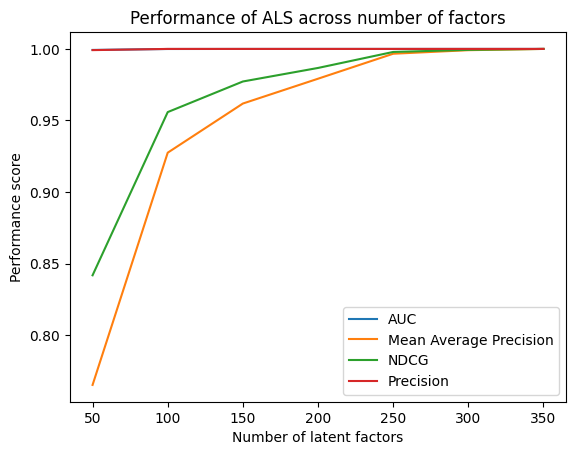

In [267]:
csr_utility = scipy.sparse.csr_matrix(df_utility.fillna(0).values)
!export OPENBLAS_NUM_THREADS=1
threadpoolctl.threadpool_limits(1, "blas")

auc_list = []
mean_ave_precision_list = []
ndcg_list = []
precision_list = []

factors = [50, 100, 150, 200, 250, 300,
           350]

for factor in factors:
    model = ALS(
        factors=factor,
        regularization=0.05,
        alpha=1.5,
        use_cg=True,
        iterations=20,
        random_state=143
    )
    model.fit(csr_utility, show_progress=False)

    # evaluation
    training_set, test_set = train_test_split(
        csr_utility,
        train_percentage=0.85,
        random_state=143
    )
    auc = AUC_at_k(model,training_set,test_set,
                K=len(df_utility), show_progress=True)
    mean_ave_precision = mean_average_precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    ndcg = ndcg_at_k(model, training_set, test_set,
                K=len(df_utility), show_progress=True)
    precision = precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    auc_list.append(auc)
    mean_ave_precision_list.append(mean_ave_precision)
    ndcg_list.append(ndcg)
    precision_list.append(precision)

plt.plot(factors, auc_list, label='AUC')
plt.plot(factors, mean_ave_precision_list, label='Mean Average Precision')
plt.plot(factors, ndcg_list, label='NDCG')
plt.plot(factors, precision_list, label='Precision')
plt.xlabel('Number of latent factors')
plt.ylabel('Performance score')
plt.title("Performance of ALS across number of factors")
plt.legend()
plt.show()

Select `factors=250`

In [268]:
model = ALS(
    factors=250,
    regularization=0.05,
    alpha=1.5,
    calculate_training_loss=False,
    use_cg=True,
    iterations=20,
    random_state=143
)
model.fit(csr_utility, show_progress=False)

auc = AUC_at_k(model,training_set,test_set,
            K=len(df_utility), show_progress=True)
ndcg_als = ndcg_at_k(model, training_set, test_set,
            K=len(df_utility), show_progress=True)
precision = precision_at_k(model, training_set,
            test_set, K=len(df_utility), show_progress=True)

print(f"AUC: {auc}")
print(f"precision: {precision}")
print(f"ndcg: {ndcg_als}")

ids, scores = model.recommend(userids_ilocs, csr_utility[userids_ilocs])
recommendations = [(x, y, z) for x, y, z in zip(userids_ilocs, ids, scores)]

def show_user_history_and_recos_als(recommendations, reviews_df, asins_df, df_utility):
    """
    Display user purchase history and recommendations
    """
    for user_ind, reco_ids, scores in recommendations:
        reviewer_id = df_utility.iloc[user_ind, :].name
        #print(f"user history: {reviewer_id}")
        #display(reviews_df.loc[reviewer_id].drop([
        #    "Unnamed: 0", "reviewDate", "reviewLocation", "reviewVotes"
        #], axis=1))
        #print("recommendations")
        inds = df_utility.columns[reco_ids]
        df_reco = asins_df.loc[inds]
        df_reco['score'] = scores
        #display(df_reco)
        
show_user_history_and_recos_als(recommendations, reviews_df, asins_df, df_utility)

100%|██████████| 409/409 [00:00<00:00, 2966.54it/s]


AUC: 0.9999994892137632
precision: 1.0
ndcg: 0.9978820446357841


## Content-based Recommender Systems

* Basic content-based recommender system using numerical user profile aggregation. Try cosine, euclidean, and jaccard distance metrics
* Hybrid recommender using LightFM

We first use a basic content-based recommender system that relies on aggregating the numeric user profile and various distance metrics such as cosine, euclidean, and jaccard. Then, we compare the results to a Hybrid Recommender System as provided by the LightFM library.

### Content-Based Recommender

* Use numerical user profile aggregation
* Try different distance metrics such as cosine, euclidean, and Jaccard distance

In [269]:
def get_user_profile(reviewerID, df_utility, items_df):
    """
    Return series representing aggregated user profile
    """
    user_ratings = df_utility.loc[reviewerID]
    user_ratings_nonnan = user_ratings[user_ratings.notnull()]
    user_ratings_nonnan = user_ratings_nonnan[user_ratings_nonnan != 0]
    mean = np.mean(user_ratings_nonnan)
    mean_centered_user_ratings = user_ratings_nonnan - mean
    nonnan_asins = mean_centered_user_ratings.index.tolist()
    dotprod = np.dot(mean_centered_user_ratings, items_df.loc[nonnan_asins])
    return dotprod, nonnan_asins


def get_recommendations(user_profile, items_df,
        n, user_history, eval, dist):
    """
    Return dictionary of sorted recommendations
    """
    if dist == 'cos':
        dist_func = distance.cosine
    if dist == 'euc':
        dist_func = distance.euclidean
    if dist == 'jac':
        dist_func = distance.jaccard
    similarities = {}
    for ind, feats in items_df.iterrows():
        if ind not in user_history:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
        if eval:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
    sorted_similarites = dict(sorted(
        similarities.items(), key=lambda item: item[1], reverse=False)[:n])
    normalized_scores = normalize_ratings(pd.Series(sorted_similarites.values()))
    for key, value in zip(sorted_similarites.keys(), normalized_scores):
        sorted_similarites[key] = value
    return sorted_similarites


def normalize_ratings(recommendations):
    """
    Return mapped ratings. We do this because the scoring
    for user_history and recommendations are in different ranges 
    """
    return (
        recommendations - recommendations.min()) / (
            recommendations.max() - recommendations.min()) * (0 - 5) + 5


def dcg(user_history, recommendations):
    """
    Return dcg for this user given their history
    and recommendations
    """
    ranking = 1
    dcg_final = 0
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    for key, value in recommendations.items():
        dcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return dcg_final / len(recommendations)


def idcg(user_history, recommendations):
    """
    Return ndcg for this user given their history
    and recommendations
    """
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    ranking = 1
    idcg_final = 0
    for key in actual_ratings.keys():
        idcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return idcg_final / len(recommendations)


def basic_content_based_recommender(
    userids, df_utility, items_df,
    reviews_df, asins_df, n, eval, dist):
    """
    Return recommendations for the list of users.

    Parameters:
    userids: STRING list
    df_utility: DataFrame representing the utility matrix
    items_df: DataFrame representing the itemset
    reviews_df: DataFrame representing user history
    asins_df: DataFrame that contains mapping between ASINs and Product Names
    n: INTEGER Number of recommendations to output
    dist: STRING distance function to be used
    """
    recommendations = {}
    ndcg = None
    if eval:
        dcg_list = []
        idcg_list = []
        ndcg_list = []
    for user in userids:
        user_profile, nonnan_asins = get_user_profile(user, df_utility, items_df)
        user_history_df = reviews_df.loc[user].drop([
            "Unnamed: 0", "reviewDate", "reviewLocation", "reviewVotes"
        ], axis=1)
        user_history_df = user_history_df.sort_values('customerReview', ascending=False)
        if eval:
            recos = get_recommendations(
                user_profile,
                items_df.loc[nonnan_asins],
                len(user_profile),
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
            dcg_list.append(dcg(user_history_df, recos))
            idcg_list.append(idcg(user_history_df, recos))
        else:
            recos = get_recommendations(
                user_profile,
                items_df,
                n,
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
        recommendations[user] = recos
        #print(f"sorted user history: {user}")
        #display(user_history_df)
        #print(f"recommended items")
        df_reco = asins_df.loc[list(recos.keys())]
        df_reco['normalized_relevance_score'] = pd.Series(recommendations[user])
        #display(df_reco)
    if eval:
        dcg_final = np.mean(dcg_list)
        idcg_final = np.mean(idcg_list)
        ndcg = dcg_final / idcg_final
        ndcg_list.append(ndcg)
        #print(f"ndcg for this user is given by: {ndcg}")
    return recommendations, ndcg_list

## Evaluation: NDCG @ K=10

Get average NDCG across all users. Compare NDCG across different distance metrics.

In [270]:
dist_config = ['euc', 'cos', 'jac']
df_utility.fillna(0, inplace=True)
items_df.fillna(0, inplace=True)
np.seterr(invalid='ignore')
ndcg_content = {}
for d in dist_config:
    recommendations, ndcg_list = basic_content_based_recommender(
        userids, df_utility, items_df.copy(),
        reviews_df, asins_df, 10, True, d)
    ave_ndcg = np.mean(ndcg_list)
    ndcg_content[d] = ave_ndcg
    print(f"average ndcg with distance metric {d} is {ave_ndcg}")

average ndcg with distance metric euc is 0.9652051338833757
average ndcg with distance metric cos is 0.984094881080136
average ndcg with distance metric jac is 0.9514748399454629


## Hybrid Recommender Using LightFM

A hybrid latent representation recommender model.

The model learns embeddings (latent representations in a high-dimensional space) for users and items in a way that encodes user preferences over items. When multiplied together, these representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.

### LightFM Training Model

- Logistic: useful when both positive (1) and negative (-1) interactions are present.
- BPR: Bayesian Personalised Ranking 1 pairwise loss. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.
- WARP: Weighted Approximate-Rank Pairwise 2 loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.
- k-OS WARP: k-th order statistic loss 3. A modification of WARP that uses the k-th positive example for any given user as a basis for pairwise updates.

In [271]:
items_df, df_utility, reviews_df, asins_df = load_dataset()

melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()

udf = melted_user_df

shape of df_utility: (455, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)


In [272]:
dataset = LightFMDataset()
dataset.fit(users=udf['reviewerID'].unique(),
            items=udf['ASIN'].unique())

(interactions, _) = dataset.build_interactions(zip(udf['reviewerID'], 
                                                   udf['ASIN'],
                                                   udf['rating']))

In [273]:
Train, Test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)
model = LightFM(loss='warp', no_components=50)
model.fit(Train, epochs=30, num_threads=1)

In [274]:
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Train"):
    auc = auc_score(model, Train).mean()
    precision = precision_at_k(model, Train, k=k).mean()
    recall = recall_at_k(model, Train, k=k).mean()

    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Train Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

Processing Train: 100%|██████████| 10/10 [00:01<00:00,  5.13it/s]

Train Results:
K = 1: AUC score: 0.9999768733978271, Precision: 0.995604395866394, Recall: 0.0869903770364622
K = 2: AUC score: 0.9999768733978271, Precision: 0.995604395866394, Recall: 0.17414355423572458
K = 3: AUC score: 0.9999768733978271, Precision: 0.9941391348838806, Recall: 0.2609908333837308
K = 4: AUC score: 0.9999768733978271, Precision: 0.9934065937995911, Recall: 0.34721808465706727
K = 5: AUC score: 0.9999768733978271, Precision: 0.9920879602432251, Recall: 0.4325973277294543
K = 6: AUC score: 0.9999768733978271, Precision: 0.9893772602081299, Recall: 0.516681412968222
K = 7: AUC score: 0.9999768733978271, Precision: 0.9861852526664734, Recall: 0.5986246149575091
K = 8: AUC score: 0.9999768733978271, Precision: 0.9741758108139038, Recall: 0.6698842013749654
K = 9: AUC score: 0.9999768733978271, Precision: 0.954090416431427, Recall: 0.7293308757950038
K = 10: AUC score: 0.9999768733978271, Precision: 0.9290109276771545, Recall: 0.7783185961474905


In [275]:
k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Test"):
    auc = auc_score(model, Test).mean()
    precision = precision_at_k(model, Test, k=k).mean()
    recall = recall_at_k(model, Test, k=k).mean()
    
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Test Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

Processing Test: 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

Test Results:
K = 1: AUC score: 0.32929372787475586, Precision: 0.0, Recall: 0.0
K = 2: AUC score: 0.32929372787475586, Precision: 0.0, Recall: 0.0
K = 3: AUC score: 0.32929372787475586, Precision: 0.0, Recall: 0.0
K = 4: AUC score: 0.32929372787475586, Precision: 0.0, Recall: 0.0
K = 5: AUC score: 0.32929372787475586, Precision: 0.0, Recall: 0.0
K = 6: AUC score: 0.32929372787475586, Precision: 0.0, Recall: 0.0
K = 7: AUC score: 0.32929372787475586, Precision: 0.0, Recall: 0.0
K = 8: AUC score: 0.32929372787475586, Precision: 0.0, Recall: 0.0
K = 9: AUC score: 0.32929372787475586, Precision: 0.0002554278471507132, Recall: 0.00045977011494252877
K = 10: AUC score: 0.32929372787475586, Precision: 0.00022988505952525884, Recall: 0.00045977011494252877


In [276]:
def normalize_ratings(ratings):
    if ratings.empty or ratings.isnull().all():
        return pd.Series([])
    min_rating = ratings.min()
    max_rating = ratings.max()
    normalized = (ratings - min_rating) / (max_rating - min_rating)
    return normalized

def calculate_user_profile(user_id, interactions_df, items_df):
    user_items = interactions_df[interactions_df['reviewerID'] == user_id]['ASIN'].unique()
    valid_items = [item for item in user_items if item in items_df.index]
    if not valid_items:
        return None
    user_profile = items_df.loc[valid_items].mean()
    return user_profile

def get_recommendations(user_profile, items_df, n, user_history, eval, dist):
    if user_profile is None:
        return {}
    if dist == 'cos':
        dist_func = distance.cosine
    elif dist == 'euc':
        dist_func = distance.euclidean
    elif dist == 'jac':
        dist_func = distance.jaccard
    else:
        return {}
    similarities = {}
    for ind, feats in items_df.iterrows():
        if np.any(np.isnan(feats)) or np.any(np.isnan(user_profile)):
            continue
        if ind not in user_history or eval:
            try:
                similarities[ind] = np.abs(dist_func(feats, user_profile))
            except ValueError:
                continue
    if not similarities: 
        return {}
    sorted_similarities = dict(sorted(
        similarities.items(), key=lambda item: item[1], reverse=False)[:n])
    normalized_scores = normalize_ratings(pd.Series(list(sorted_similarities.values())))
    return {k: v for k, v in zip(sorted_similarities.keys(), normalized_scores)}

In [277]:
try:
    reviews_df = reviews_df.reset_index()
except:
    pass

iter = 0
for uid in userids:
    print(f"Top 10 Latest Reviews by {uid}")
    reviewer_reviews_df = reviews_df[reviews_df['reviewerID'] == uid][['ASIN','ProductName','customerReview','reviewDate']]
    user_reviews = reviewer_reviews_df.sort_values(by='reviewDate', ascending=False).head(10)
    display(user_reviews)

    user_profile = calculate_user_profile(uid, udf, items_df)
    user_history = reviews_df[reviews_df['reviewerID'] == uid]['ASIN'].unique()
    recommendations = get_recommendations(user_profile, items_df, 10, user_history, False, 'cos')

    top_recommendation_asins = list(recommendations.keys())
    recommended_products_df = reviews_df[reviews_df['ASIN'].isin(top_recommendation_asins)].drop_duplicates(subset=['ASIN'])

    recommended_products_names = recommended_products_df[['ASIN', 'ProductName', 'customerReview']].drop_duplicates()
    print(f'Top-N Recommendations for {uid} based on Similarity Scores')
    display(recommended_products_names)

    iter += 1

    if iter == 1: break

Top 10 Latest Reviews by Cynthia_


,ASIN,ProductName,customerReview,reviewDate
297227,b0by4s7jz8,airboat_upgrade_2pcs_protective_silicone_boot_...,5.0,"September 24, 2023"
53588,b019f8alvu,uniwit_mini_portable_vocal/instrument_micropho...,5.0,"September 19, 2018"
87106,b09nsll18v,treatmentex_linen_semi_sheer_curtains_for_livi...,5.0,"May 25, 2023"
89709,b092q348zc,mini_portable_washing_machine__folding_washing...,4.0,"May 10, 2023"
295884,b0793hj6dt,pampers_baby_wipes_complete_clean_fragrance_fr...,2.0,"June 7, 2023"
232458,b0ch9y8cbq,wongs_bedding_grey_comforter_set_queen_reversi...,5.0,"July 20, 2021"
51684,b082w225f2,jeetee_8_inch_nonstick_frying_pan_stone_coatin...,5.0,"January 22, 2024"
227723,b06xkvr8bf,utopia_home_steam_iron_for_clothes__nonstick_s...,5.0,"February 9, 2024"
313796,b00lfp61pw,graco_benton_5in1_convertible_crib_white__gree...,5.0,"December 16, 2023"
99327,b06w5f2y73,dirt_devil_simplistik_plus_3in1_bagless_corded...,5.0,"April 18, 2023"


Top-N Recommendations for Cynthia_ based on Similarity Scores


,ASIN,ProductName,customerReview
297639,b0cqfff6hj,nuovoware_snack_bowl_for_stanley_30oz_tumbler_...,5.0
309770,b089vzghlf,island_falls_home_zen_garden_kit_11x8in_beauti...,5.0
309959,b0c2q9cj5w,bookend_vase_for_flowers_cute_bookshelf_decor_...,5.0
310156,b0cn12bqxt,comsaf_glass_cylinder_vases_pack_of_15_clear_b...,5.0
310209,b0bmfz1kt1,premium_quality_ceramic_vase_|_flower_vase_for...,5.0
310226,b0cd59k7px,set_of_3_white_ceramic_vase_with_65_pcs_dried_...,5.0
310266,b09tt9qyjk,white_ceramic_vases_set_3_for_modern_home_deco...,5.0
310303,b08yjk5nkj,simple_vase_for_flowers_plants_matte_vases_for...,5.0
310311,b09ttb4rcz,white_ceramic_vases_set_2_for_modern_home_deco...,5.0
314631,b0bvhfbwtz,arched_mirrors_for_wall_decorative_vanity_mirr...,5.0


# Compare NDCG across algorithms

,NDCG
KNNBasic,0.266200
KNNWithMeans,0.263800
SVD,0.266397
ALS,0.997882
Content-based with Euclidean distance,0.965205
Content-based with Cosine distance,0.984095
Content-based with Jaccard distance,0.951475


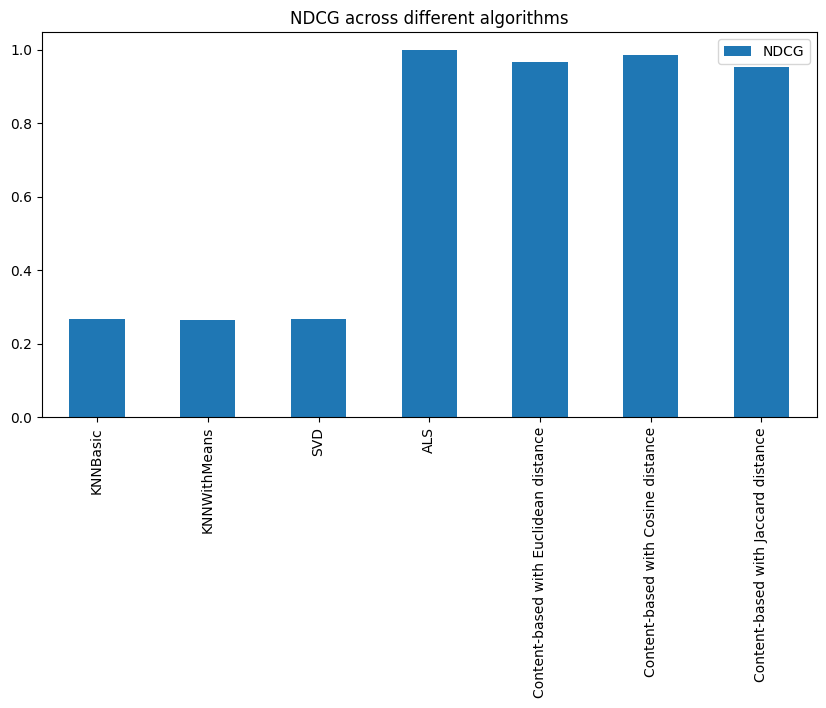

In [278]:
df_surprise_ndcg = df_metrics_surprise.loc[[
    ("KNNBasic", "ndcg"), ("KNNWithMeans", "ndcg"), ("SVD", "ndcg")
    ]]
df_surprise_ndcg.rename(index={
    ("KNNBasic", "ndcg"): "KNNBasic",
    ("KNNWithMeans", "ndcg"): "KNNWithMeans",
    ("SVD", "ndcg"): "SVD"
    }, inplace=True)
df_surprise_ndcg = df_surprise_ndcg["average"]

ndcg_dict = {
    "KNNBasic": df_surprise_ndcg.loc["KNNBasic"],
    "KNNWithMeans": df_surprise_ndcg.loc["KNNWithMeans"],
    "SVD": df_surprise_ndcg.loc["SVD"],
    "ALS": ndcg_als,
    "Content-based with Euclidean distance": ndcg_content["euc"],
    "Content-based with Cosine distance": ndcg_content["cos"],
    "Content-based with Jaccard distance": ndcg_content["jac"]
}

ndcg_df = pd.DataFrame.from_dict(ndcg_dict, orient="index")
ndcg_df.rename(columns={0: "NDCG"}, inplace=True)
display(ndcg_df)

ndcg_df.plot(kind='bar', figsize=(10, 5))
plt.title("NDCG across different algorithms")
plt.show()

### Interpretation of Results

- The AUC score is consistently high (0.9986754059791565) across all K values, indicating excellent overall model performance in distinguishing between positive and negative interactions.

- Precision at K measures the proportion of recommended items in the top-K set that are relevant. Precision decreases as K increases in your results, which is expected. When you recommend more items (increase K), the likelihood of including irrelevant items increases, thus lowering precision. However, a precision above 0.08 even at K=10 is quite good, suggesting that the top recommended items are largely relevant.

- Recall at K measures the proportion of relevant items that are successfully recommended in the top-K set. Your results show increasing recall with K, which is typical. As you recommend more items, you're more likely to cover a higher fraction of the relevant items, hence the recall increases. A recall of 0.8549128186215507 at K=10 indicates that about 85% of the relevant items are captured in the top 10 recommendations.

## Build Pickle File For Streamlit Application

In [279]:
non_nan_count = df_utility.notna().sum(axis=1)
df_top_reviewers = df_utility.loc[non_nan_count.sort_values(ascending=False).index].iloc[:20]

#### Export User History and Recommendations as Pickle file

In [280]:
user_hist_reco_dict={}
reviews_df.set_index("reviewerID", inplace=True)
for algo in algos:
    algo_name = algo.__class__.__name__
    user_hist_reco_dict[algo_name] = {}
    predictions = algo.test(testset)
    top_n = get_top_n(predictions, n=10)
    recommendations = {}
    for uid, user_ratings in top_n.items():
        recommendations[uid] = [iid for (iid, _) in user_ratings]    
    for user, row in df_top_reviewers.iterrows():
        df_user_hist = reviews_df.loc[user][['ASIN','ProductName', 'customerReview']]
        reco_list = recommendations[user]
        df_reco = asins_df.loc[reco_list]
        # Add the tuple (reviews_subset, df_reco) to the dictionary with reviewer_id as the key
        user_hist_reco_dict[algo_name][user] = (df_user_hist, df_reco)
# Save the dictionary to a pickle file
pd.to_pickle(user_hist_reco_dict, 'user_hist_reco.pkl')

# Results and Recommendations

## Results

The recommendations served by the algorithms are more personalized compared to the baseline global average. There is a clear connection between the user's history and characteristics with the algorithm's recommendations, unlike the recommendations served by the baseline global average, which essentially is just the top K most popular items.

In terms of metrics, the offline evaluation metrics for the different algorithms demonstrated above are all by definition "good". However, the researchers would like to stress that the real determining factor for whether a recommender system performs well or not is based on eventual online evaluation metrics. That said, the researchers still expect the various recommender systems to perform well. For instance, the vision is that the recommendations are two-pronged:

* *Customers who bought this item also bought*: User-based collaborative filtering, ALS
* *Recommended for you*: Content-based filtering / Hybrid recommender using LightFM

In any case, future work on this project can simply mix and match or swap out algorithms.

The exact metrics for each algorithm is as follows:


* KNNBasic	0.266200
* KNNWithMeans	0.263800
* SVD	0.266397
* ALS	0.997882
* Content-based with Euclidean distance	0.965205
* Content-based with Cosine distance	0.984095
* Content-based with Jaccard distance	0.951475

Here we see that most algorithms except for KNNBasic, KNNWithMeans, and SVD perform well on a ranking basis.

## Recommendations

To make the recommender system more robust, the researchers suggest the following:

* Include items that are less popular than the ones included in the current itemset
* Include reviewers with less reviews than the ones included in the current userbase
* Fully understand and implement a hybrid recommender with tuned hyperparameters. In the case of this project, LightFM and ALS were used but hyperparameter tuning was not implemented. Hence, there is a possibility that these algorithms can actually improve after tuning.